In [25]:
import argparse

import torch

from accelerate import Accelerator, DeepSpeedPlugin

from accelerate import DistributedDataParallelKwargs

from torch import nn, optim

from torch.optim import lr_scheduler

from tqdm import tqdm



from models import Autoformer, DLinear, TimeLLM



from data_provider.data_factory import data_provider

import time

import random

import numpy as np

import os



os.environ['CURL_CA_BUNDLE'] = ''

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"



from utils.tools import del_files, EarlyStopping, adjust_learning_rate, vali, load_content


fix_seed = 2021

random.seed(fix_seed)

torch.manual_seed(fix_seed)

np.random.seed(fix_seed)

In [35]:
ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)

deepspeed_plugin = DeepSpeedPlugin(hf_ds_config='./ds_config_zero2.json')

accelerator = Accelerator(kwargs_handlers=[ddp_kwargs], deepspeed_plugin=deepspeed_plugin)


In [26]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from models import TimeLLM
from data_provider.data_factory import data_provider
import time

In [27]:
import torch

In [28]:
class Args:
    def __init__(self):
        self.task_name = 'long_term_forecast'
        self.is_training = 1
        self.model_id = 'EAN_512_96'
        self.model_comment = 'TimeLLM-EAN'
        self.model = 'TimeLLM'
        self.seed = 2021
        self.data = 'ean'
        self.root_path = './dataset'
        self.data_path = 'data.csv'
        self.features = 'S'
        self.target = 'sold_units'
        self.loader = 'modal'
        self.freq = 'h'
        self.checkpoints = './checkpoints/'
        self.seq_len = 13
        self.label_len = 1
        self.pred_len = 1
        self.seasonal_patterns = 'Monthly'
        self.enc_in = 9
        self.dec_in = 9
        self.c_out = 9
        self.d_model = 32
        self.n_heads = 8  # Typically set by your model configuration
        self.e_layers = 2  # Typically set by your model configuration
        self.d_layers = 1  # Typically set by your model configuration
        self.d_ff = 128
        self.moving_avg = 25  # Assume default if not specified in the script
        self.factor = 3
        self.dropout = 0.1  # Assume default if not specified
        self.embed = 'timeF'  # Assume default if not specified
        self.activation = 'gelu'  # Assume default if not specified
        self.output_attention = False  # Assume default if not specified
        self.patch_len = 16  # Assume default if not specified
        self.stride = 8  # Assume default if not specified
        self.prompt_domain = 0  # Assume default if not specified
        self.llm_model = 'GPT2'
        self.llm_dim = 768
        self.num_workers = 10  # Default setting
        self.itr = 1
        self.train_epochs = 2
        self.align_epochs = 10  # Assume default if not specified
        self.batch_size = 7
        self.eval_batch_size = 8  # Assume default if not specified
        self.patience = 10  # Assume default if not specified
        self.learning_rate = 0.001
        self.des = 'Exp'
        self.loss = 'MSE'  # Assume default if not specified
        self.lradj = 'type1'  # Assume default if not specified
        self.pct_start = 0.2  # Assume default if not specified
        self.use_amp = False  # Assume default based on your environment capabilities
        self.llm_layers = 32
        self.percent = 100  # Assume default if not specified

# Instantiate the Args
args = Args()

In [43]:
path = 'checkpoints/long_term_forecast_EAN_512_96_TimeLLM_ean_ftS_sl13_ll1_pl1_dm32_nh8_el2_dl1_df128_fc3_ebtimeF_Exp_0-TimeLLM-EAN/checkpoint'

# Load the checkpoint
checkpoint = torch.load(path)

In [44]:
model = TimeLLM.Model(args).float()

In [45]:
model.load_state_dict(torch.load(path), strict=False)

<All keys matched successfully>

In [46]:
# Set the model to evaluation mode

model.eval()

Model(
  (llm_model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-31): 32 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (padding_patch_layer): ReplicationPad1d()
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(16, 

In [47]:
train_data, train_loader = data_provider(args, 'train')

vali_data, vali_loader = data_provider(args, 'val')

test_data, test_loader = data_provider(args, 'test')



time_now = time.time()



train_steps = len(train_loader)

early_stopping = EarlyStopping(accelerator=accelerator, patience=args.patience)



trained_parameters = []

for p in model.parameters():

    if p.requires_grad is True:

        trained_parameters.append(p)



model_optim = optim.Adam(trained_parameters, lr=args.learning_rate)



if args.lradj == 'COS':

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optim, T_max=20, eta_min=1e-8)

else:

    scheduler = lr_scheduler.OneCycleLR(optimizer=model_optim,

                                        steps_per_epoch=train_steps,

                                        pct_start=args.pct_start,

                                        epochs=args.train_epochs,

                                        max_lr=args.learning_rate)



train_loader, vali_loader, test_loader, model, model_optim, scheduler = accelerator.prepare(

        train_loader, vali_loader, test_loader, model, model_optim, scheduler)

AttributeError: 'list' object has no attribute 'shape'

In [92]:
from torch.cuda.amp import autocast, GradScaler

# Setup scaler for managing precision
scaler = GradScaler()
predictions = list()
true_labels = list()
with torch.no_grad():  # No need to compute gradients during inference
    for batch_x, batch_y, batch_x_mark, batch_y_mark in test_loader:
        batch_x = batch_x.float().to(accelerator.device)
        batch_y = batch_y.float().to(accelerator.device)
        batch_x_mark = batch_x_mark.float().to(accelerator.device)
        batch_y_mark = batch_y_mark.float().to(accelerator.device)

        # Prepare decoder input as zeros initially, similar to training phase setup
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).to(accelerator.device)
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1)

        # Using autocast for automatic mixed precision
        with autocast():
            if args.output_attention:
                output, _ = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            output = output[:, -args.pred_len:, :]  # Adjust based on the output dimensions if needed

        predictions.append(output.cpu().numpy())
        true_labels.append(batch_y[:, -args.pred_len:, :].cpu().numpy())
# Convert list of arrays to a single numpy array
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)


In [93]:
true_labels[:,0]


array([[143.],
       [238.],
       [190.],
       [145.],
       [126.],
       [198.],
       [149.]], dtype=float32)

In [82]:
true_labels[0,2,0]

array([190.], dtype=float32)

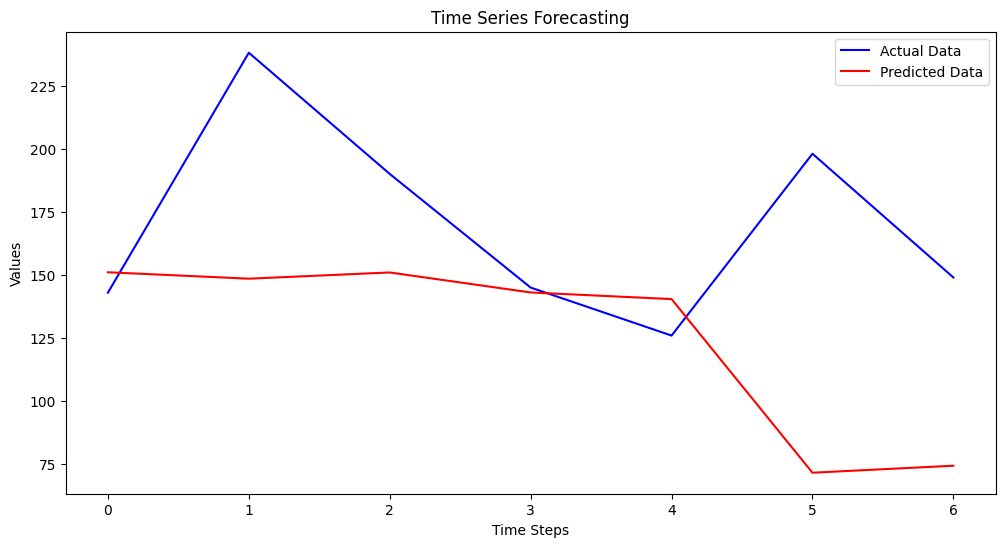

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[:, 0], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[:, 0], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()